<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 188 (delta 51), reused 40 (delta 40), pack-reused 130
Receiving objects: 100% (188/188), 6.56 MiB | 8.77 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [3]:
SEED = 42 # fix random seed for reproducibility

## Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [4]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.26G/1.28G [00:12<00:00, 110MB/s]
100% 1.28G/1.28G [00:12<00:00, 108MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Get rid of some unnecessary infomation

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## Balance the dataset

In [8]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [9]:
num_min = 300
num_max = 400

utils.categories_as_strings(df) # take "category" as a column of strings

# Drop the lists of categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# Sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2309.11558,Estimating major merger rates and spin paramet...,"['astro-ph.CO', 'astro-ph.GA']",We build a model to predict from first princ...
1,2307.13732,The Timeless Timing Argument and the Mass of t...,"['astro-ph.CO', 'astro-ph.GA']",The Timing Argument connects the motion of a...
2,2302.10960,Simulating the LOcal Web (SLOW): I. Anomalies ...,"['astro-ph.CO', 'astro-ph.GA']",Context: Several observations of the local U...
3,2310.08633,Constraining the AGN luminosity function from ...,"['astro-ph.CO', 'astro-ph.GA']",We predict the X-ray background (XRB) expect...
4,2402.01983,Searching for cosmological variation of the pr...,"['astro-ph.CO', 'astro-ph.GA']",Exploring physics beyond General Relativity ...


Visualize the dataset distribution.

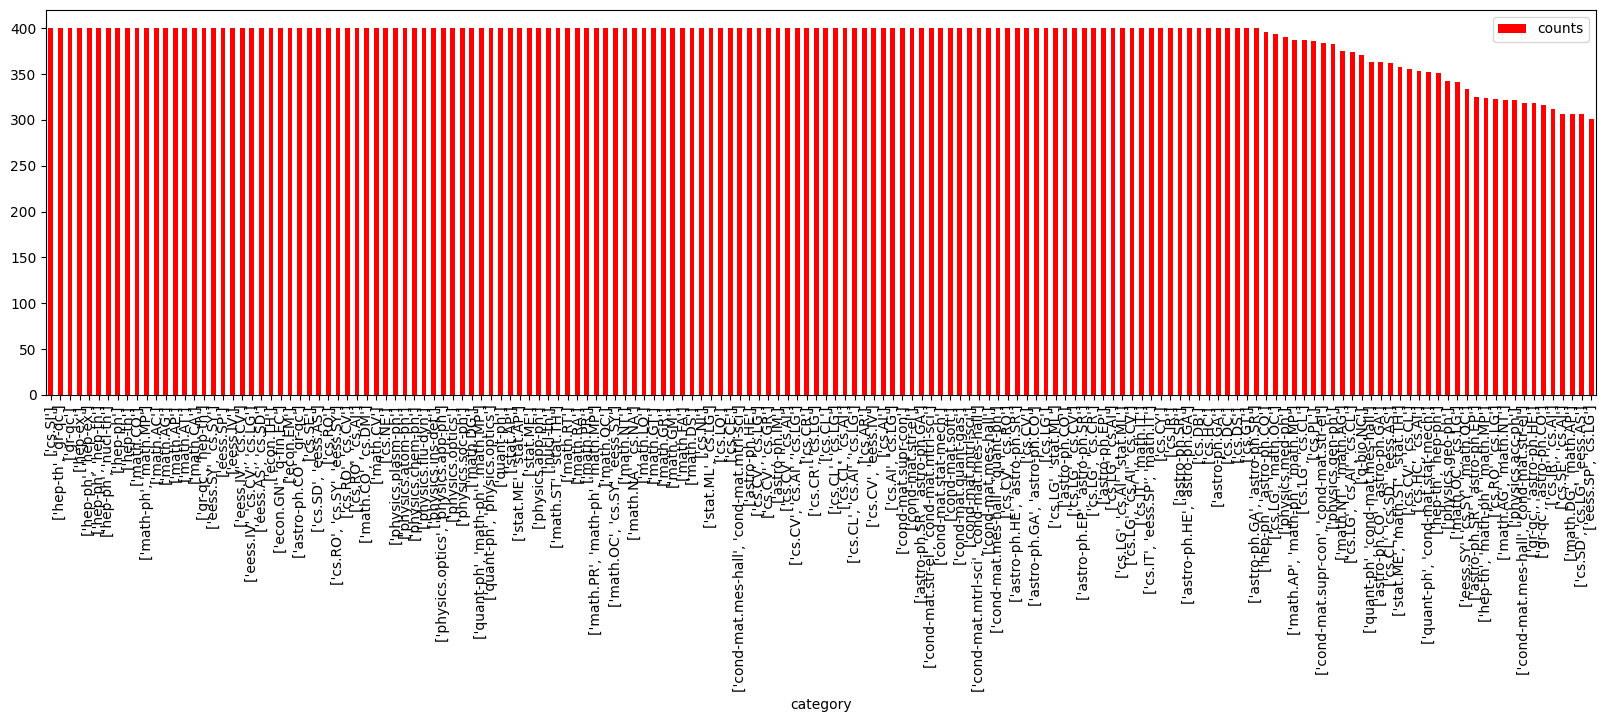

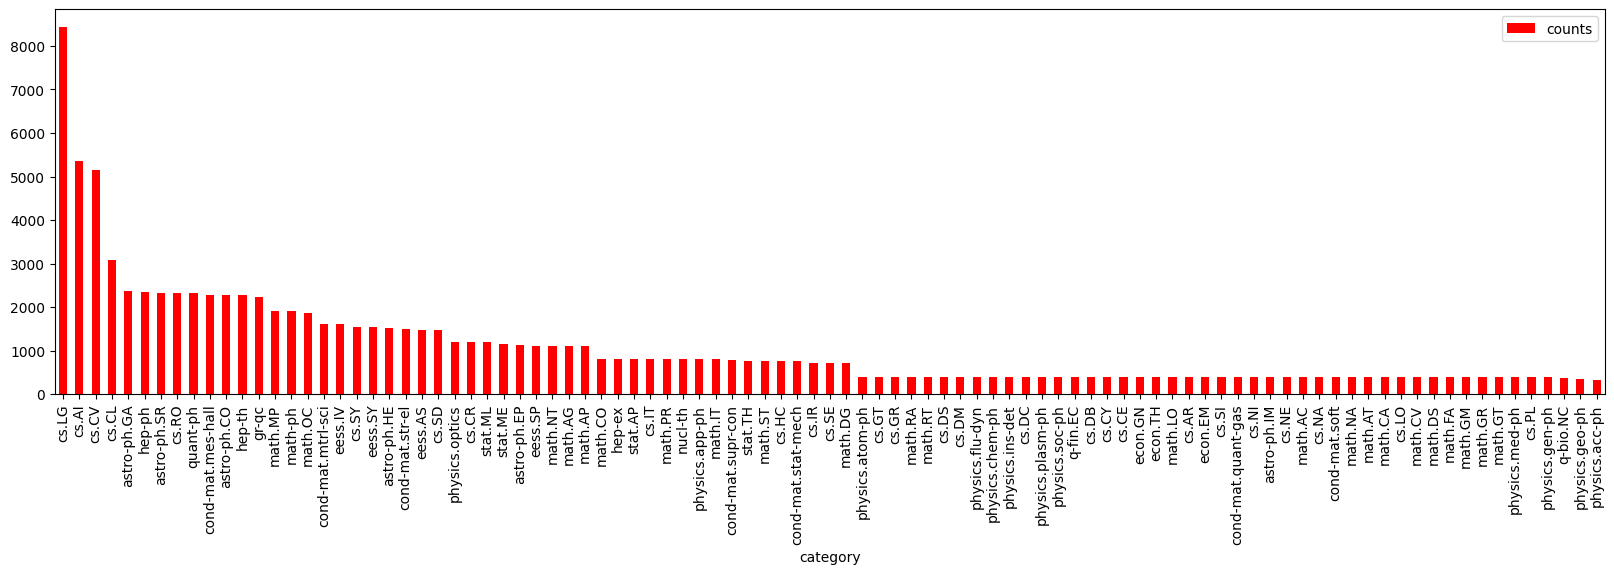

In [10]:
# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")


# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

In [11]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
df = df.loc[df['category'].explode().isin(sub_C).loc[lambda x: x].index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,2309.11558,Estimating major merger rates and spin paramet...,"[astro-ph.CO, astro-ph.GA]",We build a model to predict from first princ...
1,2307.13732,The Timeless Timing Argument and the Mass of t...,"[astro-ph.CO, astro-ph.GA]",The Timing Argument connects the motion of a...
2,2302.10960,Simulating the LOcal Web (SLOW): I. Anomalies ...,"[astro-ph.CO, astro-ph.GA]",Context: Several observations of the local U...
3,2310.08633,Constraining the AGN luminosity function from ...,"[astro-ph.CO, astro-ph.GA]",We predict the X-ray background (XRB) expect...
4,2402.01983,Searching for cosmological variation of the pr...,"[astro-ph.CO, astro-ph.GA]",Exploring physics beyond General Relativity ...


## Get a fixed number of articles
To speed up computation and avoid a session crash.

In [45]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

df.to_csv("./dataset_to_classify.csv", index=False)
print(f"The dataset contains {len(df)} articles.")

The dataset contains 18715 articles.
The dataset contains 1000 articles.


# 2) Multilabel Classification X=abs+tit y=cat


In [13]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.5 MB/s eta 0:00:00


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer,normalize
from sklearn.svm import SVC, LinearSVC

In [46]:
path = "./dataset_to_classify.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,text,keywords
995,2309.11538,Massive Type IIB Superstrings I: 3- 4-Point Am...,['hep-th'],present 3- 4-point tree-level scattering ampli...,present point tree level scatter amplitude inv...,massive type iib superstrings i point amplitude,massive type iib superstrings i point amplitud...,"['superstrings', 'amplitude', 'massless', 'iib']"
996,2312.04195,Possible gapless helical edge states hydrogena...,"['cond-mat.mes-hall', 'cond-mat.mtrl-sci']",Electronic band structures hydrogenated graphe...,electronic band structure hydrogenate graphene...,possible gapless helical edge state hydrogenat...,possible gapless helical edge state hydrogenat...,"['graphene', 'hydrogenation', 'gap', 'topologi..."
997,2402.19356,Trans-series condensates,"['hep-th', 'hep-ph']",Shifman-Vainshtein-Zakharov (SVZ) sum rules pr...,shifman vainshtein zakharov svz sum rule provi...,trans series condensate,trans series condensate shifman vainshtein zak...,"['series', 'fermion', 'perturbative', 'condens..."
998,2012.12046,Rationality problem two-dimensional quasi-mono...,"['math.AG', 'math.NT']",rationality problem two-dimensional purely qua...,rationality problem two dimensional purely qua...,rationality problem two dimensional quasi mono...,rationality problem two dimensional quasi mono...,"['rationality', 'monomial', 'quasi', 'order']"
999,2306.15431,Two-Loop Feynman Integrals Five-Point One-Mass...,"['hep-ph', 'hep-th']",compute complete set two-loop master integrals...,compute complete set two loop master integral ...,two loop feynman integral five point one mass ...,two loop feynman integral five point one mass ...,"['integral', 'lhc', 'feynman', 'loop']"


In [47]:
# Preparing X (features).
X = df["title"] + df["abstract"]


# Preparing y (labels) as a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

Visualize y as a one-hot encoding.

In [48]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.GA,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.str-el,cs.AI,cs.AR,cs.CE,cs.CV,cs.DB,...,math.AC,math.AG,math.CV,math.IT,math.MP,math.NT,math.PR,math.RT,q-fin.EC,quant-ph
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


Do the classification.

In [18]:
model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = utils.run_model_multi(model, X_train, X_test, y_train, y_test)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

accuracy = 0.611219946571683

                   precision    recall  f1-score   support

      astro-ph.CO       0.94      0.94      0.94       646
      astro-ph.GA       0.84      0.85      0.85       230
cond-mat.mes-hall       0.99      0.97      0.98       677
cond-mat.mtrl-sci       0.78      0.64      0.71       228
  cond-mat.str-el       0.83      0.36      0.50       105
            cs.AI       0.55      0.38      0.45       326
            cs.AR       0.91      0.75      0.82       115
            cs.CE       0.90      0.50      0.64       129
            cs.CV       0.80      0.67      0.73       248
            cs.DB       0.89      0.70      0.78       130
            cs.DC       0.90      0.63      0.74       116
            cs.HC       0.90      0.75      0.82       227
            cs.IR       0.99      0.87      0.93       214
            cs.IT       0.75      0.69      0.72       119
            cs.LG       0.65      0.32      0.43       189
            cs.NE       0

Plot confusion matrices.

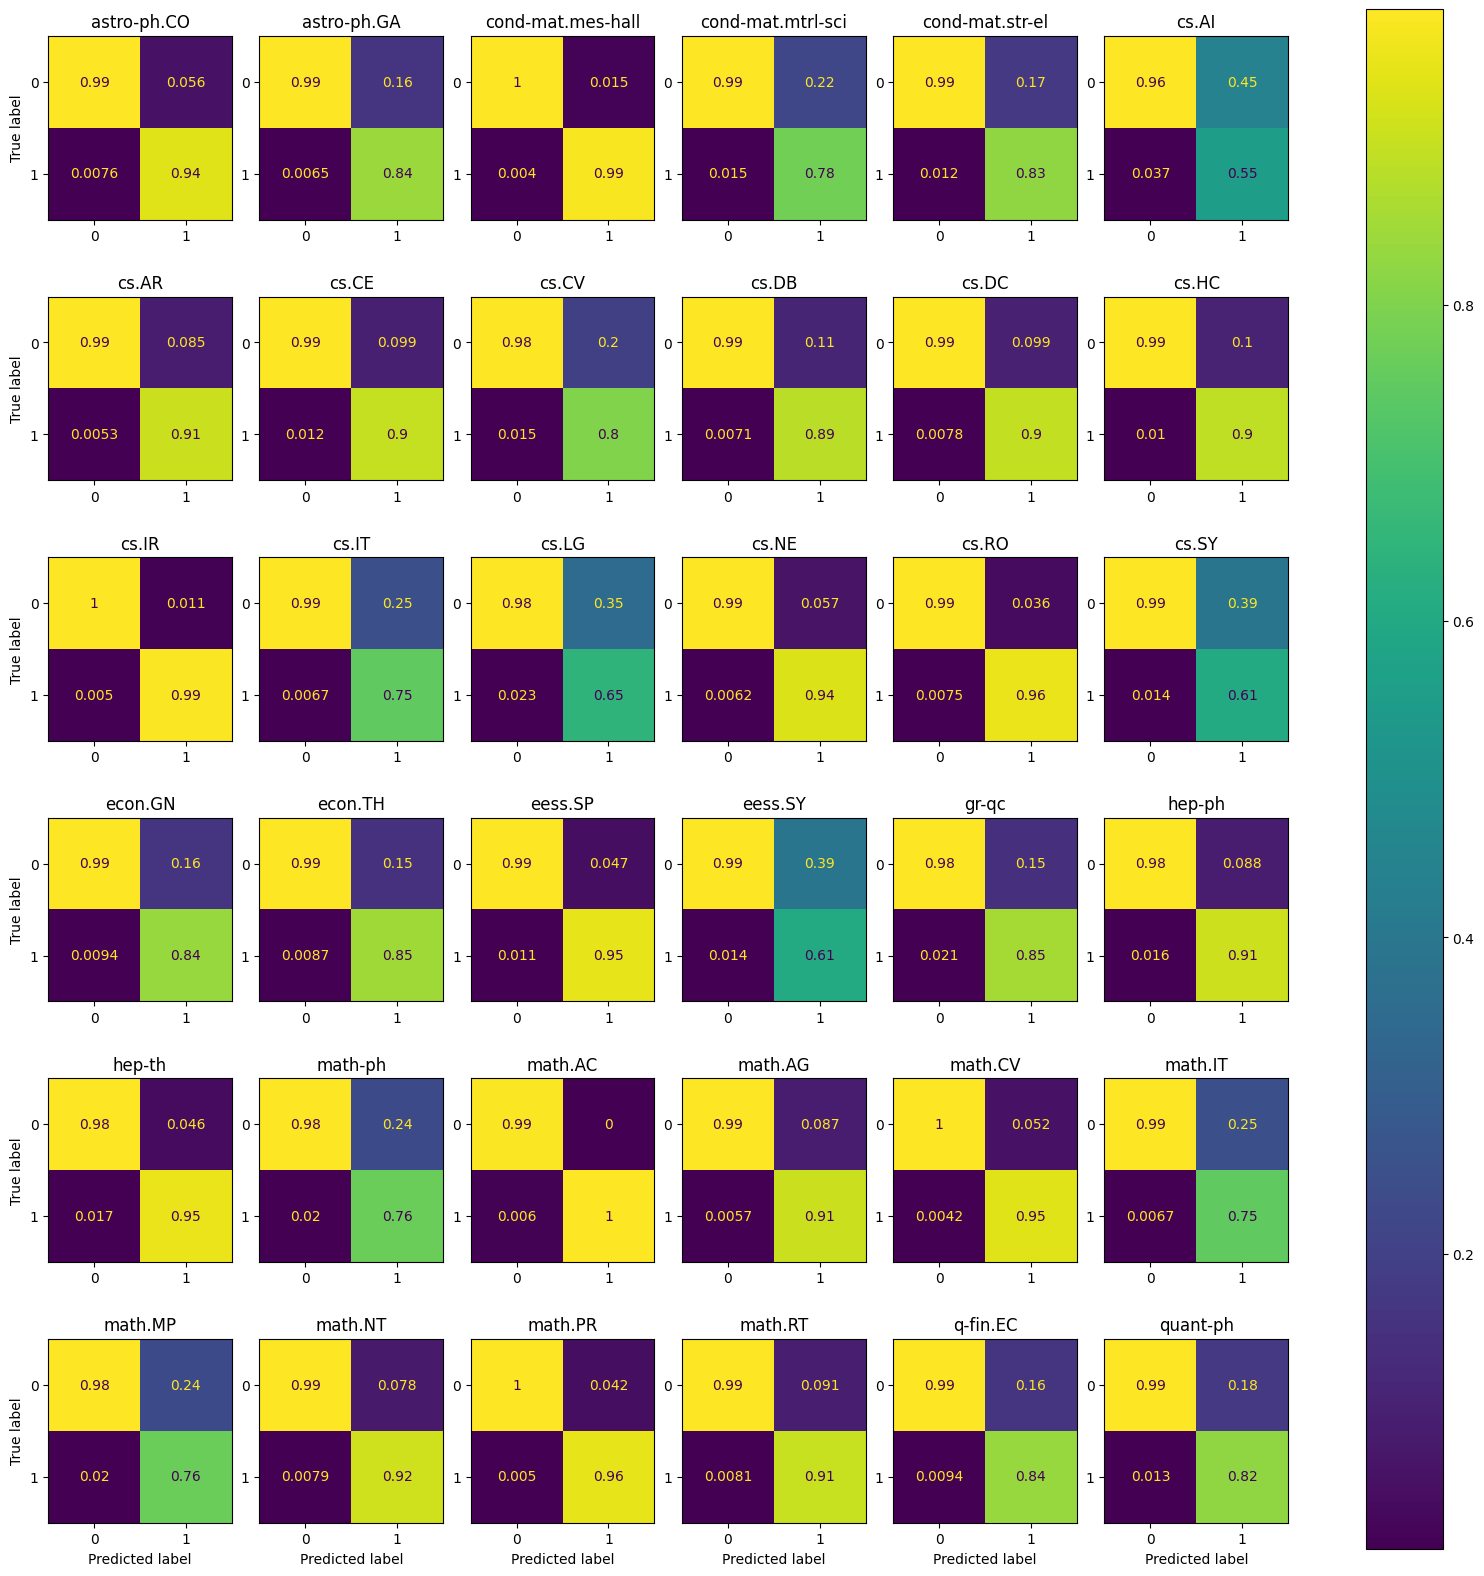

In [19]:
utils.print_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [20]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ('cs.AI', 'cs.LG', 'cs.RO')
--------------------
  true   : ('hep-th', 'math-ph', 'math.MP')
predicted: ('hep-th',)
--------------------
  true   : ('math.AG', 'math.NT')
predicted: ('math.AG', 'math.NT')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('math.CV',)
predicted: ('math.CV',)
--------------------
  true   : ('astro-ph.CO', 'hep-ph')
predicted: ('astro-ph.CO', 'hep-ph')
--------------------
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.CO', 'astro-ph.GA')
--------------------
  true   : ('cs.RO',)
predicted: ('cs.RO',)
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('hep-th',)


Plot the ROC curve.

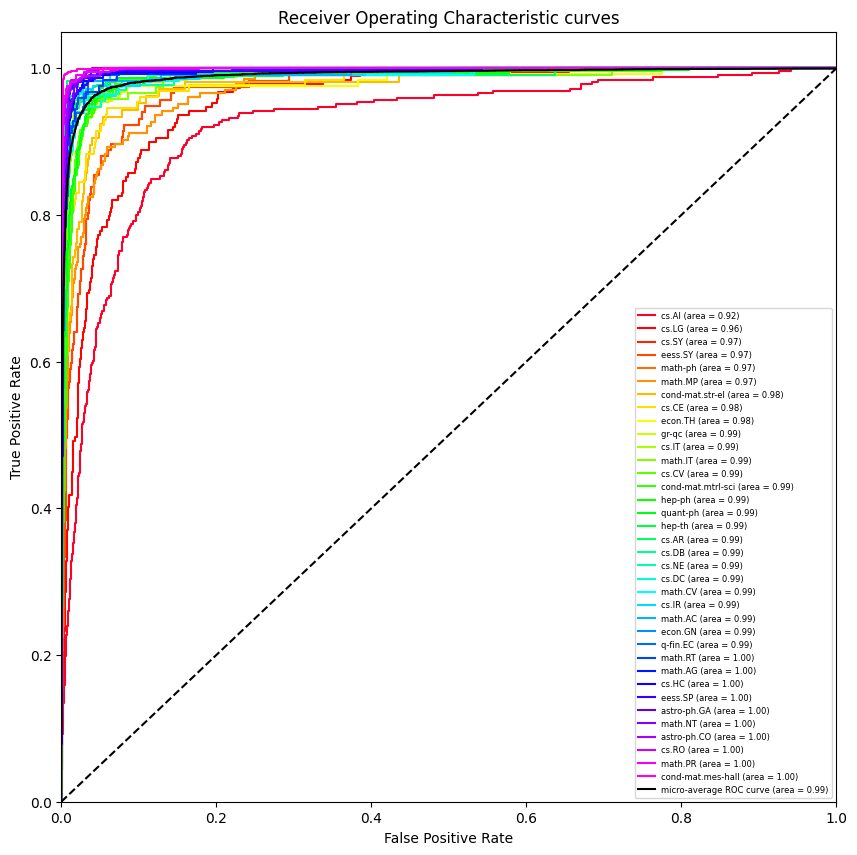

In [21]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

# 3) Keywords extraction

In [66]:
!pip install KeyBERT -q
!pip install keyphrase-vectorizers -q
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [69]:
import en_core_web_md
from keybert import KeyBERT
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [70]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
clean_abs = lambda x: utils.remove(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(clean_abs, axis=1)

# Then on titles.
clean_tit = lambda x: utils.remove(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(clean_tit, axis=1)

df.tail()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 1000/1000 [00:07<00:00, 141.29it/s]


,id,title,category,abstract,clean_abstract,clean_title,text,keywords
995,2309.11538,Massive Type IIB Superstrings I: 3- 4-Point Am...,['hep-th'],present 3- 4-point tree-level scattering ampli...,present point tree level scatter amplitude inv...,massive type iib superstrings i point amplitudes,massive type iib superstrings i point amplitud...,"['superstrings', 'amplitude', 'massless', 'iib']"
996,2312.04195,Possible gapless helical edge states hydrogena...,"['cond-mat.mes-hall', 'cond-mat.mtrl-sci']",Electronic band structures hydrogenated graphe...,electronic band structure hydrogenate graphene...,possible gapless helical edge state hydrogenat...,possible gapless helical edge state hydrogenat...,"['graphene', 'hydrogenation', 'gap', 'topologi..."
997,2402.19356,Trans-series condensates,"['hep-th', 'hep-ph']",Shifman-Vainshtein-Zakharov (SVZ) sum rules pr...,shifman vainshtein zakharov svz sum rule provi...,tran series condensate,trans series condensate shifman vainshtein zak...,"['series', 'fermion', 'perturbative', 'condens..."
998,2012.12046,Rationality problem two-dimensional quasi-mono...,"['math.AG', 'math.NT']",rationality problem two-dimensional purely qua...,rationality problem two dimensional purely qua...,rationality problem two dimensional quasi mono...,rationality problem two dimensional quasi mono...,"['rationality', 'monomial', 'quasi', 'order']"
999,2306.15431,Two-Loop Feynman Integrals Five-Point One-Mass...,"['hep-ph', 'hep-th']",compute complete set two-loop master integrals...,compute complete set two loop master integral ...,two loop feynman integral five point one mass ...,two loop feynman integral five point one mass ...,"['integral', 'lhc', 'feynman', 'loop']"


In [71]:
# Add a space to separate title and abstract.
df["clean_title"] = df["clean_title"].astype(str) + " "
df["text"] = df["clean_title"] + df["clean_abstract"]

# Save to csv
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,clean_abstract,clean_title,text,keywords
0,2312.05660,Galois Cohomology Reductive Groups Function Fi...,"['math.NT', 'math.AG']",global field (number field function field curv...,global field number field function field curve...,galois cohomology reductive groups function fi...,galois cohomology reductive groups function fi...,"['galois', 'cohomology', 'reductive', 'localiz..."
1,2310.03721,Singlet-doublet fermion dark matter Dirac neut...,"['hep-ph', 'astro-ph.CO']",study possibility generating light Dirac neutr...,study possibility generate light dirac neutrin...,singlet doublet fermion dark matter dirac neut...,singlet doublet fermion dark matter dirac neut...,"['neutrino', 'dirac', 'cmb', 'doublet']"
2,2310.12658,phyloDB: framework large-scale phylogenetic an...,['cs.DB'],phyloDB modular extensible framework large-sca...,phylodb modular extensible framework large sca...,phylodb framework large scale phylogenetic ana...,phylodb framework large scale phylogenetic ana...,"['phylogenetic', 'phylodb', 'epidemic', 'datab..."
3,2303.09985,Exp function Edwards curves local fields,"['math.NT', 'math.AG']",extend map Exp elliptic curves short Weierstra...,extend map exp elliptic curve short weierstras...,exp function edwards curve local field,exp function edwards curve local field extend ...,"['edwards', 'extend', 'curve', 'local']"
4,2208.12913,Euler-Heisenberg Lagrangian axial gauge field,"['hep-th', 'hep-ph']",Augmentations Euler-Heisenberg Lagrangian (QED...,augmentations euler heisenberg lagrangian qed ...,euler heisenberg lagrangian axial gauge field,euler heisenberg lagrangian axial gauge field ...,"['dirac', 'lagrangian', 'axial', 'gauge']"


## Extract the keywords

In [61]:
df2 = df.copy(deep=False)

kw_model = KeyBERT('all-mpnet-base-v2')
extraction = lambda x: utils.extract_kws(TEXT=x["text"],
                                   kw_model=kw_model,
                                   seed=x["clean_title"].split(" "))
df2["keywords"] = df2.progress_apply(extraction, axis=1)
df2.head()

100%|██████████| 1000/1000 [01:29<00:00, 11.18it/s]


,id,title,category,abstract,clean_abstract,clean_title,text,keywords
0,2312.05660,Galois Cohomology Reductive Groups Function Fi...,"['math.NT', 'math.AG']",global field (number field function field curv...,global field number field function field curve...,galois cohomology reductive groups function fi...,galois cohomology reductive groups function fi...,"[galois, cohomology, reductive, localization]"
1,2310.03721,Singlet-doublet fermion dark matter Dirac neut...,"['hep-ph', 'astro-ph.CO']",study possibility generating light Dirac neutr...,study possibility generate light dirac neutrin...,singlet doublet fermion dark matter dirac neut...,singlet doublet fermion dark matter dirac neut...,"[neutrino, dirac, cmb, doublet]"
2,2310.12658,phyloDB: framework large-scale phylogenetic an...,['cs.DB'],phyloDB modular extensible framework large-sca...,phylodb modular extensible framework large sca...,phylodb framework large scale phylogenetic ana...,phylodb framework large scale phylogenetic ana...,"[phylogenetic, phylodb, epidemic, database]"
3,2303.09985,Exp function Edwards curves local fields,"['math.NT', 'math.AG']",extend map Exp elliptic curves short Weierstra...,extend map exp elliptic curve short weierstras...,exp function edwards curve local field,exp function edwards curve local field extend ...,"[edwards, extend, curve, local]"
4,2208.12913,Euler-Heisenberg Lagrangian axial gauge field,"['hep-th', 'hep-ph']",Augmentations Euler-Heisenberg Lagrangian (QED...,augmentations euler heisenberg lagrangian qed ...,euler heisenberg lagrangian axial gauge field,euler heisenberg lagrangian axial gauge field ...,"[dirac, lagrangian, axial, gauge]"


In [62]:
df2.to_csv(f"./keywords.csv", index=False) # Save to csv

# 4) Classification X=kws, y=cat


In [63]:
path = "./keywords.csv"
df = pd.read_csv(path, dtype=str)
df.tail()

,id,title,category,abstract,clean_abstract,clean_title,text,keywords
995,2309.11538,Massive Type IIB Superstrings I: 3- 4-Point Am...,['hep-th'],present 3- 4-point tree-level scattering ampli...,present point tree level scatter amplitude inv...,massive type iib superstrings i point amplitude,massive type iib superstrings i point amplitud...,"['superstrings', 'amplitude', 'massless', 'iib']"
996,2312.04195,Possible gapless helical edge states hydrogena...,"['cond-mat.mes-hall', 'cond-mat.mtrl-sci']",Electronic band structures hydrogenated graphe...,electronic band structure hydrogenate graphene...,possible gapless helical edge state hydrogenat...,possible gapless helical edge state hydrogenat...,"['graphene', 'hydrogenation', 'gap', 'topologi..."
997,2402.19356,Trans-series condensates,"['hep-th', 'hep-ph']",Shifman-Vainshtein-Zakharov (SVZ) sum rules pr...,shifman vainshtein zakharov svz sum rule provi...,trans series condensate,trans series condensate shifman vainshtein zak...,"['series', 'fermion', 'perturbative', 'condens..."
998,2012.12046,Rationality problem two-dimensional quasi-mono...,"['math.AG', 'math.NT']",rationality problem two-dimensional purely qua...,rationality problem two dimensional purely qua...,rationality problem two dimensional quasi mono...,rationality problem two dimensional quasi mono...,"['rationality', 'monomial', 'quasi', 'order']"
999,2306.15431,Two-Loop Feynman Integrals Five-Point One-Mass...,"['hep-ph', 'hep-th']",compute complete set two-loop master integrals...,compute complete set two loop master integral ...,two loop feynman integral five point one mass ...,two loop feynman integral five point one mass ...,"['integral', 'lhc', 'feynman', 'loop']"


In [64]:
# Preparing X (features).
X = df["keywords"]


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [65]:
y_pred, mat = utils.run_model_multi(model, X_train, X_test, y_train, y_test)

print(f'accuracy = {accuracy_score(y_test, y_pred)}\n')
print(classification_report(y_test, y_pred,
                            target_names=classes, zero_division=0.0))

accuracy = 0.21333333333333335

                   precision    recall  f1-score   support

      astro-ph.CO       0.88      0.82      0.85        34
      astro-ph.GA       0.78      0.70      0.74        10
cond-mat.mes-hall       0.94      0.82      0.88        40
cond-mat.mtrl-sci       0.00      0.00      0.00        12
  cond-mat.str-el       0.00      0.00      0.00         4
            cs.AI       0.38      0.17      0.23        18
            cs.AR       0.00      0.00      0.00         5
            cs.CE       0.00      0.00      0.00         6
            cs.CV       0.50      0.25      0.33        12
            cs.DB       1.00      0.25      0.40         8
            cs.DC       0.00      0.00      0.00         5
            cs.HC       1.00      0.13      0.24        15
            cs.IR       0.88      0.47      0.61        15
            cs.IT       0.00      0.00      0.00         5
            cs.LG       0.00      0.00      0.00         9
            cs.NE      

Plot confusion matrices.

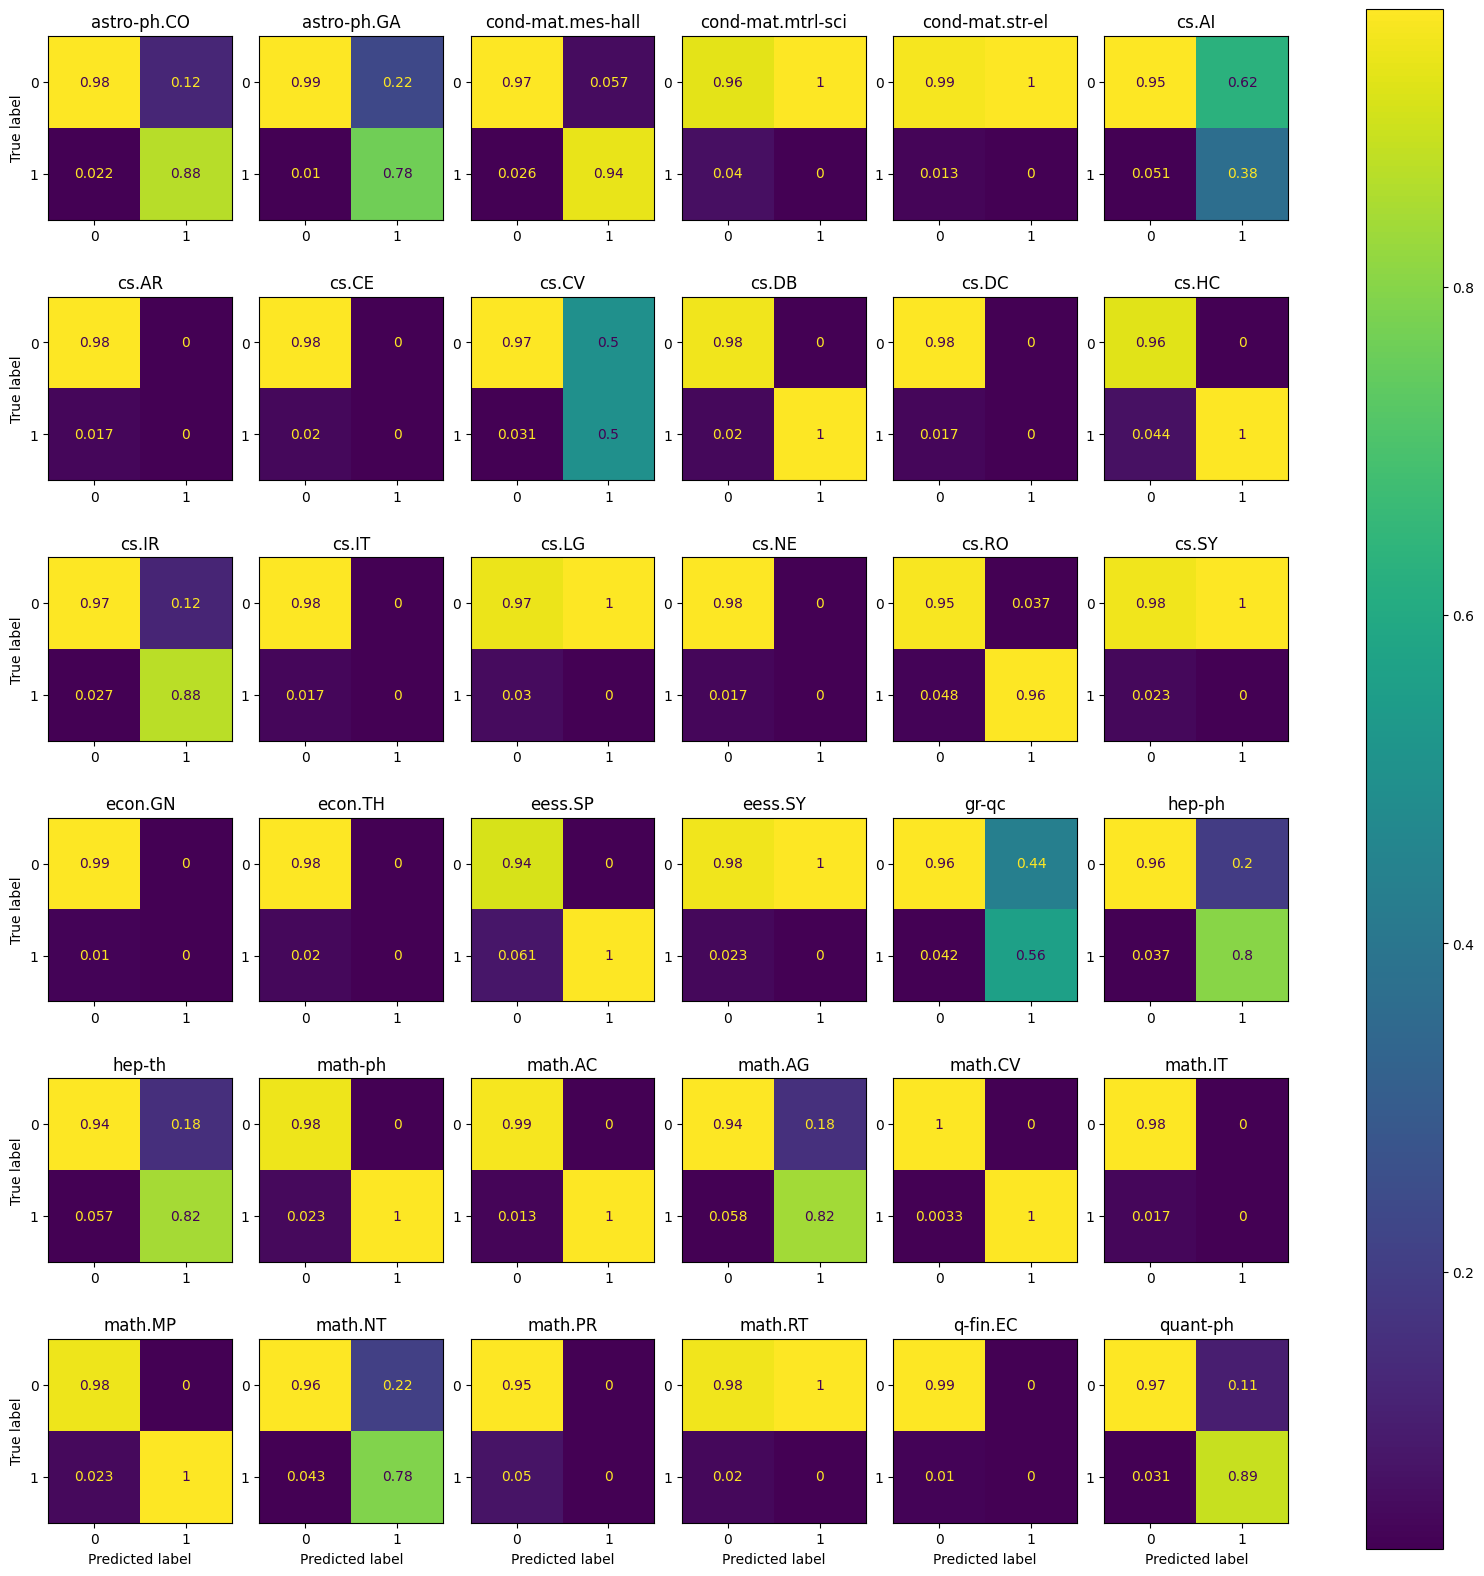

In [57]:
utils.print_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [ ]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('cs.AI', 'cs.RO')
predicted: ('cs.AI', 'cs.LG', 'cs.RO')
--------------------
  true   : ('hep-th', 'math-ph', 'math.MP')
predicted: ('hep-th',)
--------------------
  true   : ('math.AG', 'math.NT')
predicted: ('math.AG', 'math.NT')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('math.CV',)
predicted: ('math.CV',)
--------------------
  true   : ('astro-ph.CO', 'hep-ph')
predicted: ('astro-ph.CO', 'hep-ph')
--------------------
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.CO', 'astro-ph.GA')
--------------------
  true   : ('cs.RO',)
predicted: ('cs.RO',)
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('gr-qc', 'hep-th')
--------------------
  true   : ('gr-qc', 'hep-th')
predicted: ('hep-th',)


Plot the ROC curve.

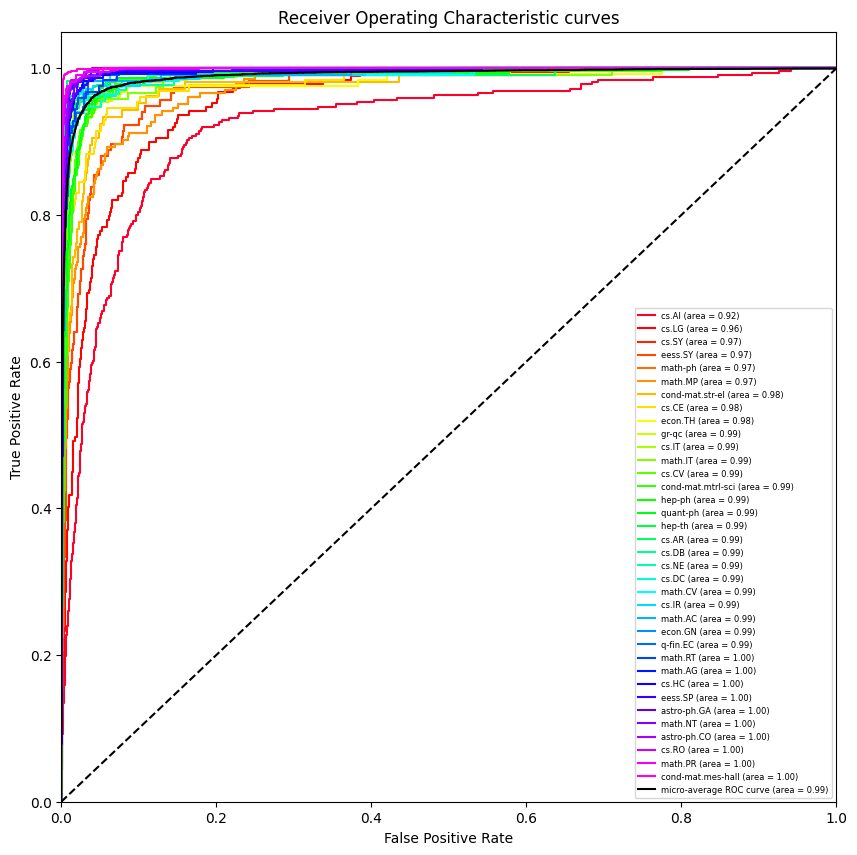

In [ ]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)